https://github.com/microsoft/AIforEarthDataSets/blob/main/data/gbif.md

The snapshot includes all CC-BY licensed data published through GBIF that have coordinates which passed automated quality checks.

https://data-blog.gbif.org/post/gbif-filtering-guide/

In [1]:
import pystac_client # access STAC catalogs
import planetary_computer # sign items
import dask.dataframe as dd

# ----- accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)


# ----- access items in gbif catalog
search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}
#list(items)


# ---- select and sign first item
item = list(items.values())[0]
#print(item)

signed_asset = planetary_computer.sign(item).assets["data"]


# ---- read data frame using parquet, specify columns
df = dd.read_parquet(
    signed_asset.href,
    columns=["species",
            "stateprovince",
            "decimallatitude",
            "decimallongitude"],
    storage_options=signed_asset.extra_fields["table:storage_options"],  #???
)
#df

# ---- select first chunk
#chunk = df.get_partition(0).compute()
#print(type(chunk))
#chunk

In [30]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.587901b4ef284590abaf094e68aa1d11/status


In [3]:
ca_obs = df.loc[df['stateprovince'] == 'California'].compute()
ca_obs


,species,stateprovince,decimallatitude,decimallongitude
3875,Abronia villosa,California,34.319103,-116.680059
3876,Abronia villosa,California,34.503286,-117.027881
3878,Abronia villosa,California,32.678805,-115.688532
3879,Abronia villosa,California,32.717605,-115.949697
3880,Abronia villosa,California,32.936057,-116.252384
...,...,...,...,...
549810,None,California,33.929100,-115.948000
549814,None,California,33.929100,-115.948000
549817,None,California,33.929100,-115.948000
549820,None,California,33.929100,-115.948000


In [4]:
# ---- OPENING SHAPEFILE ----

import geopandas as gpd # to open shapefile

sedg_shp_path = "/home/jovyan/Sedgwick_Reserve/sedgwick_geometry/sedgwick_geometry.shp"
sedg_shp = gpd.read_file(sedg_shp_path)
#sedg_shp.plot(edgecolor='purple', color='yellow')
print(sedg_shp.bounds)
sedg_shp.crs

          minx           miny         maxx          maxy
0 -6562.160984 -370851.846513 -1075.576535 -363609.35433


<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
sedg_shp = sedg_shp.to_crs(4326)
sedg_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
sedg_shp.crs

minx = sedg_shp.bounds['minx'][0]
miny = sedg_shp.bounds['miny'][0]
maxx = sedg_shp.bounds['maxx'][0]
maxy = sedg_shp.bounds['maxy'][0]



In [7]:
sedg = ca_obs.loc[(miny < ca_obs['decimallatitude'] ) & (ca_obs['decimallatitude'] < maxy) &
          (minx < ca_obs['decimallongitude'] ) & (ca_obs['decimallongitude'] < maxx)]
sedg

,species,stateprovince,decimallatitude,decimallongitude
1266426,Asclepias eriocarpa,California,34.743758,-120.070431
1270237,Viola pedunculata,California,34.741834,-120.061790
163032,Cyphelium brachysporum,California,34.692800,-120.041700
1209724,Platystemon californicus,California,34.731286,-120.026394
1724400,Turdus migratorius,California,34.692570,-120.040550
...,...,...,...,...
727408,Polioptila caerulea,California,34.692570,-120.040550
779796,Vulpia myuros,California,34.738333,-120.071667
352394,Salix lasiolepis,California,34.723751,-120.025538
392486,Solidago californica,California,34.723751,-120.025538


In [8]:
import geopandas

gdf = geopandas.GeoDataFrame(
    sedg, 
    geometry = geopandas.points_from_xy(x=sedg.decimallongitude, y=sedg.decimallatitude)
)
gdf

,species,stateprovince,decimallatitude,decimallongitude,geometry
1266426,Asclepias eriocarpa,California,34.743758,-120.070431,POINT (-120.07043 34.74376)
1270237,Viola pedunculata,California,34.741834,-120.061790,POINT (-120.06179 34.74183)
163032,Cyphelium brachysporum,California,34.692800,-120.041700,POINT (-120.04170 34.69280)
1209724,Platystemon californicus,California,34.731286,-120.026394,POINT (-120.02639 34.73129)
1724400,Turdus migratorius,California,34.692570,-120.040550,POINT (-120.04055 34.69257)
...,...,...,...,...,...
727408,Polioptila caerulea,California,34.692570,-120.040550,POINT (-120.04055 34.69257)
779796,Vulpia myuros,California,34.738333,-120.071667,POINT (-120.07167 34.73833)
352394,Salix lasiolepis,California,34.723751,-120.025538,POINT (-120.02554 34.72375)
392486,Solidago californica,California,34.723751,-120.025538,POINT (-120.02554 34.72375)


In [9]:
gdf = gdf.filter(items=['species', 'geometry'])
gdf

,species,geometry
1266426,Asclepias eriocarpa,POINT (-120.07043 34.74376)
1270237,Viola pedunculata,POINT (-120.06179 34.74183)
163032,Cyphelium brachysporum,POINT (-120.04170 34.69280)
1209724,Platystemon californicus,POINT (-120.02639 34.73129)
1724400,Turdus migratorius,POINT (-120.04055 34.69257)
...,...,...
727408,Polioptila caerulea,POINT (-120.04055 34.69257)
779796,Vulpia myuros,POINT (-120.07167 34.73833)
352394,Salix lasiolepis,POINT (-120.02554 34.72375)
392486,Solidago californica,POINT (-120.02554 34.72375)


In [10]:
# ----- ASSIGN CRS TO geodataframe -----

print(gdf.crs)
gdf = gdf.set_crs(4326)
gdf.crs

None


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

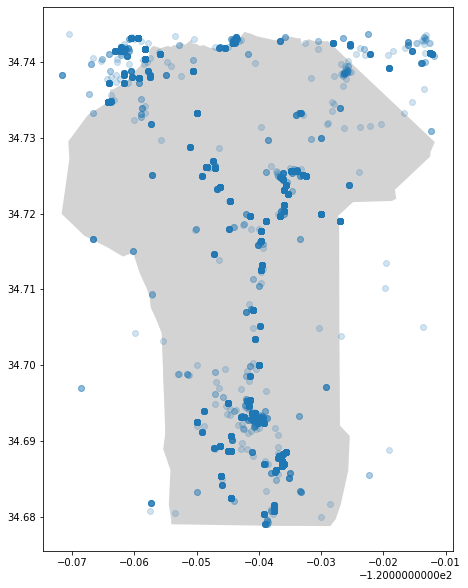

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
#sb_shape.plot(ax=ax, color='lightgrey')
sedg_shp.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, alpha=0.2)


In [ ]:
species_per_country = chunk.groupby("countrycode").species.nunique()



In [17]:
common_species = gdf.groupby("species").nunique().sort_values(by = 'geometry', ascending=False)

common_species.head(15) # all are birds

,geometry
species,
Aphelocoma californica,54
Melanerpes formicivorus,51
Sialia mexicana,47
Baeolophus inornatus,41
Buteo jamaicensis,36
Callipepla californica,36
Haemorhous mexicanus,35
Pica nuttalli,35
Junco hyemalis,35


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 1

In [ ]:
df_class = dd.read_parquet(
    signed_asset.href,
    columns=["class",
            "species",
            "stateprovince",
            "decimallatitude",
            "decimallongitude"],
    storage_options=signed_asset.extra_fields["table:storage_options"],  #???
)

# decided to compare coordinates first

#ca_obs = df_class.loc[df['stateprovince'] == 'California'].compute()
#ca_obs

#sedg = df_class.loc[(miny < ca_obs['decimallatitude'] ) & (ca_obs['decimallatitude'] < maxy) &
#          (minx < ca_obs['decimallongitude'] ) & (ca_obs['decimallongitude'] < maxx)].compute()
#sedg

In [31]:
ca_obs = df_class.loc[df_class['stateprovince'] == 'California'].compute()


,class,species,stateprovince,decimallatitude,decimallongitude
3875,Magnoliopsida,Abronia villosa,California,34.319103,-116.680059
3876,Magnoliopsida,Abronia villosa,California,34.503286,-117.027881
3878,Magnoliopsida,Abronia villosa,California,32.678805,-115.688532
3879,Magnoliopsida,Abronia villosa,California,32.717605,-115.949697
3880,Magnoliopsida,Abronia villosa,California,32.936057,-116.252384
...,...,...,...,...,...
549810,Insecta,None,California,33.929100,-115.948000
549814,Insecta,None,California,33.929100,-115.948000
549817,Insecta,None,California,33.929100,-115.948000
549820,Insecta,None,California,33.929100,-115.948000


In [ ]:
sedg = ca_obs.loc[(miny < ca_obs['decimallatitude'] ) & (ca_obs['decimallatitude'] < maxy) &
          (minx < ca_obs['decimallongitude'] ) & (ca_obs['decimallongitude'] < maxx)]


In [37]:
sedg = sedg.loc[sedg['class'] == 'Mammalia']
sedg

,class,species,stateprovince,decimallatitude,decimallongitude
1404729,Mammalia,Canis latrans,California,34.693089,-120.039739
68091,Mammalia,Ursus americanus,California,34.725243,-120.037037
808924,Mammalia,Canis latrans,California,34.693419,-120.044678
492460,Mammalia,Otospermophilus beecheyi,California,34.696944,-120.068611
514043,Mammalia,Otospermophilus beecheyi,California,34.696944,-120.068611
515430,Mammalia,Otospermophilus beecheyi,California,34.696944,-120.068611
1201642,Mammalia,Sorex ornatus,California,34.733235,-120.033688
290685,Mammalia,Microtus californicus,California,34.692400,-120.039200
295015,Mammalia,Microtus californicus,California,34.692400,-120.039200
306126,Mammalia,Microtus californicus,California,34.692400,-120.039200


In [41]:
sedg['species'].unique()

array(['Canis latrans', 'Ursus americanus', 'Otospermophilus beecheyi',
       'Sorex ornatus', 'Microtus californicus',
       'Reithrodontomys megalotis', 'Peromyscus maniculatus',
       'Peromyscus californicus', 'Thomomys bottae',
       'Odocoileus hemionus', None, 'Peromyscus boylii'], dtype=object)